In [1]:
!pip install -U autogluon > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import warnings
import datetime as dt
import matplotlib.dates as mdates
warnings.filterwarnings('ignore')
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
data = pd.read_csv('/kaggle/input/superstore-dataset-final/Sample - Superstore.csv', parse_dates=['Order Date','Ship Date'], encoding='ISO-8859-1')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

In [4]:
data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [5]:
data['Region'].value_counts()

Region
West       3203
East       2848
Central    2323
South      1620
Name: count, dtype: int64

In [6]:
data['Category'].value_counts()

Category
Office Supplies    6026
Furniture          2121
Technology         1847
Name: count, dtype: int64

In [7]:
data['Sub-Category'].value_counts()

Sub-Category
Binders        1523
Paper          1370
Furnishings     957
Phones          889
Storage         846
Art             796
Accessories     775
Chairs          617
Appliances      466
Labels          364
Tables          319
Envelopes       254
Bookcases       228
Fasteners       217
Supplies        190
Machines        115
Copiers          68
Name: count, dtype: int64

In [8]:
data.nunique()

Row ID           9994
Order ID         5009
Order Date       1237
Ship Date        1334
Ship Mode           4
Customer ID       793
Customer Name     793
Segment             3
Country             1
City              531
State              49
Postal Code       631
Region              4
Product ID       1862
Category            3
Sub-Category       17
Product Name     1850
Sales            5825
Quantity           14
Discount           12
Profit           7287
dtype: int64

In [9]:
static_features_df = data[['Sub-Category','Category']].value_counts().index.to_frame().reset_index(drop=True)
static_features_df

,Sub-Category,Category
0,Binders,Office Supplies
1,Paper,Office Supplies
2,Furnishings,Furniture
3,Phones,Technology
4,Storage,Office Supplies
5,Art,Office Supplies
6,Accessories,Technology
7,Chairs,Furniture
8,Appliances,Office Supplies
9,Labels,Office Supplies


In [10]:
quantity_data = data.groupby(['Order Date','Sub-Category']).agg({'Quantity': 'sum',
                                                 'Sales':'sum',
                                                 'Profit': 'sum'
                                                }).reset_index()
quantity_data

,Order Date,Sub-Category,Quantity,Sales,Profit
0,2014-01-03,Paper,2,16.448,5.5512
1,2014-01-04,Binders,2,3.540,-5.4870
2,2014-01-04,Labels,3,11.784,4.2717
3,2014-01-04,Storage,3,272.736,-64.7748
4,2014-01-05,Art,3,19.536,4.8840
...,...,...,...,...,...
6558,2017-12-30,Appliances,2,209.300,56.5110
6559,2017-12-30,Binders,7,87.400,30.7848
6560,2017-12-30,Bookcases,4,323.136,12.1176
6561,2017-12-30,Fasteners,3,3.024,-0.6048


In [11]:
quantity_data_irregular = TimeSeriesDataFrame.from_data_frame(
    quantity_data,
    id_column="Sub-Category",
    timestamp_column="Order Date",
    static_features_df=static_features_df
)
quantity_data_irregular

,,Quantity,Sales,Profit
item_id,timestamp,,,
Paper,2014-01-03,2,16.448,5.5512
Binders,2014-01-04,2,3.540,-5.4870
Labels,2014-01-04,3,11.784,4.2717
Storage,2014-01-04,3,272.736,-64.7748
Art,2014-01-05,3,19.536,4.8840
...,...,...,...,...
Appliances,2017-12-30,2,209.300,56.5110
Binders,2017-12-30,7,87.400,30.7848
Bookcases,2017-12-30,4,323.136,12.1176


In [12]:
quantity_data_regular = quantity_data_irregular.convert_frequency(freq="D")
quantity_data_regular.isna().sum()

Quantity    17868
Sales       17868
Profit      17868
dtype: int64

In [13]:
quantity_data_regular

Quantity     Sales     Profit
item_id timestamp                                
Paper   2014-01-03       2.0    16.448     5.5512
        2014-01-04       NaN       NaN        NaN
        2014-01-05       NaN       NaN        NaN
        2014-01-06       4.0    25.980    12.3396
        2014-01-07       NaN       NaN        NaN
...                      ...       ...        ...
Copiers 2017-12-20       NaN       NaN        NaN
        2017-12-21       NaN       NaN        NaN
        2017-12-22       NaN       NaN        NaN
        2017-12-23       NaN       NaN        NaN
        2017-12-24       6.0  2879.952  1007.9832

[24431 rows x 3 columns]

In [14]:
quantity_datas_filled = quantity_data_regular.sort_index().fill_missing_values(method="constant", value=0)
quantity_datas_filled.isna().sum()

Quantity    0
Sales       0
Profit      0
dtype: int64

In [15]:
quantity_datas_filled

Quantity     Sales    Profit
item_id     timestamp                               
Accessories 2014-01-09       3.0    31.200    9.7500
            2014-01-10       0.0     0.000    0.0000
            2014-01-11       0.0     0.000    0.0000
            2014-01-12       0.0     0.000    0.0000
            2014-01-13       6.0   646.740  258.6960
...                          ...       ...       ...
Tables      2017-12-21       0.0     0.000    0.0000
            2017-12-22      12.0  2136.826 -217.1994
            2017-12-23       0.0     0.000    0.0000
            2017-12-24       0.0     0.000    0.0000
            2017-12-25       2.0   273.060 -104.6730

[24431 rows x 3 columns]

# FE

In [ ]:
def create_circular_lag_features(df, column='Quantity', lag_periods=[1, 7]):
    """
    Create circular lag features to avoid initial missing values
    """
    df_features = df.copy()
    n = len(df_features)
    
    for lag in lag_periods:
        feature_name = f'{column}_lag_{lag}'
        # Create normal lag features
        df_features[feature_name] = df_features[column].shift(lag)
        
        # Fill initial missing values with data from the end
        df_features.loc[df_features.index[:lag], feature_name] = df_features[column].iloc[-(lag):].values
    
    return df_features

def create_circular_rolling_mean(df, column='Quantity', windows=[7]):
    """
    Calculate initial rolling average using circular data
    """
    df_features = df.copy()
    
    for window in windows:
        feature_name = f'{column}_rolling_mean_{window}'
        
        # Calculate normal rolling average
        df_features[feature_name] = df_features[column].rolling(window=window).mean()
        
        # Handle initial missing values
        for i in range(window-1):
            # Concatenate end data to beginning to calculate initial values
            temp_series = pd.concat([
                df_features[column].iloc[-(window-1-i):],
                df_features[column].iloc[:i+1]
            ])
            df_features.loc[df_features.index[i], feature_name] = temp_series.mean()
            
    return df_features

def create_circular_rolling_std(df, column='Quantity', windows=[7]):
    """
    Calculate initial rolling standard deviation using circular data
    """
    df_features = df.copy()
    
    for window in windows:
        feature_name = f'{column}_rolling_mean_{window}'
        
        # Calculate normal rolling standard deviation
        df_features[feature_name] = df_features[column].rolling(window=window).std()
        
        # Handle initial missing values
        for i in range(window-1):
            # Concatenate end data to beginning to calculate initial values
            temp_series = pd.concat([
                df_features[column].iloc[-(window-1-i):],
                df_features[column].iloc[:i+1]
            ])
            df_features.loc[df_features.index[i], feature_name] = temp_series.std()
            
    return df_features


def create_features(df):
    # Extract time features
    df['year'] = df.index.get_level_values(1).year
    df['month'] = df.index.get_level_values(1).month
    df['weekday'] = df.index.get_level_values(1).dayofweek
    df['quarter'] = df.index.get_level_values(1).quarter
    df['is_weekend'] = df.index.get_level_values(1).dayofweek.isin([5, 6]).astype(int)

    # Add lag features
    df = create_circular_lag_features(df, column='Quantity', lag_periods=[1, 7])

    # Add rolling statistical features
    df = create_circular_rolling_mean(df, column='Quantity', windows=[7])
    df = create_circular_rolling_std(df, column='Quantity', windows=[7])

        # 2. Exponential moving average
    df['rolling_ema_7'] = df['Quantity'].ewm(span=7).mean()

    
    return df

In [17]:
quantity_datas_filled_fe = create_features(quantity_datas_filled)
quantity_datas_filled_fe

Quantity     Sales    Profit  year  month  weekday  \
item_id     timestamp                                                        
Accessories 2014-01-09       3.0    31.200    9.7500  2014      1        3   
            2014-01-10       0.0     0.000    0.0000  2014      1        4   
            2014-01-11       0.0     0.000    0.0000  2014      1        5   
            2014-01-12       0.0     0.000    0.0000  2014      1        6   
            2014-01-13       6.0   646.740  258.6960  2014      1        0   
...                          ...       ...       ...   ...    ...      ...   
Tables      2017-12-21       0.0     0.000    0.0000  2017     12        3   
            2017-12-22      12.0  2136.826 -217.1994  2017     12        4   
            2017-12-23       0.0     0.000    0.0000  2017     12        5   
            2017-12-24       0.0     0.000    0.0000  2017     12        6   
            2017-12-25       2.0   273.060 -104.6730  2017     12        0   

                        quarter  is_weekend  Quantity_lag_1  Quantity_lag_7  \
item_id     timestamp                                                         
Accessories 2014-01-09        1           0             2.0             0.0   
            2014-01-10        1           0             3.0             0.0   
            2014-01-11        1           1             0.0             0.0   
            2014-01-12        1           1             0.0            12.0   
            2014-01-13        1           0             0.0             0.0   
...                         ...         ...             ...             ...   
Tables      2017-12-21        4           0             0.0             6.0   
            2017-12-22        4           0             0.0             0.0   
            2017-12-23        4           1            12.0             0.0   
            2017-12-24        4           1             0.0             0.0   
            2017-12-25        4           0             0.0             0.0   

                        Quantity_rolling_mean_7  rolling_ema_7  
item_id     timestamp                                           
Accessories 2014-01-09                 4.391550       3.000000  
            2014-01-10                 4.391550       1.285714  
            2014-01-11                 4.391550       0.729730  
            2014-01-12                 1.253566       0.462857  
            2014-01-13                 2.299068       2.277849  
...                                         ...            ...  
Tables      2017-12-21                 0.000000       0.452201  
            2017-12-22                 4.535574       3.339151  
            2017-12-23                 4.535574       2.504363  
            2017-12-24                 4.535574       1.878272  
            2017-12-25                 4.472136       1.908704  

[24431 rows x 12 columns]

## Add Holiday Features

In [18]:
import holidays

timestamps = quantity_datas_filled_fe.index.get_level_values("timestamp")
country_holidays = holidays.country_holidays(
    country="US",  # make sure to select the correct country/region!
    # Add + 2 year to make sure that holidays are initialized for the forecast horizon
    years=range(timestamps.min().year, timestamps.max().year + 2),
)
# # Convert dict to pd.Series for pretty visualization
pd.Series(country_holidays).sort_index().tail()

2018-10-08               Columbus Day
2018-11-11               Veterans Day
2018-11-12    Veterans Day (observed)
2018-11-22               Thanksgiving
2018-12-25              Christmas Day
dtype: object

In [19]:
# country_holidays

In [20]:
def add_holiday_features(
    ts_df: TimeSeriesDataFrame,
    country_holidays: dict,
    include_individual_holidays: bool = True,
    include_holiday_indicator: bool = True,
) -> TimeSeriesDataFrame:
    """Add holiday indicator columns to a TimeSeriesDataFrame."""
    ts_df = ts_df.copy()
    timestamps = ts_df.index.get_level_values("timestamp")
    country_holidays_df = pd.get_dummies(pd.Series(country_holidays)).astype(float)
    holidays_df = country_holidays_df.reindex(timestamps.date).fillna(0)
    if include_individual_holidays:
        ts_df[holidays_df.columns] = holidays_df.values
    if include_holiday_indicator:
        ts_df["Holiday"] = holidays_df.max(axis=1).values
    return ts_df

In [21]:
data_with_holidays = add_holiday_features(quantity_datas_filled_fe, country_holidays)
data_with_holidays.head()

Quantity   Sales   Profit  year  month  weekday  \
item_id     timestamp                                                     
Accessories 2014-01-09       3.0   31.20    9.750  2014      1        3   
            2014-01-10       0.0    0.00    0.000  2014      1        4   
            2014-01-11       0.0    0.00    0.000  2014      1        5   
            2014-01-12       0.0    0.00    0.000  2014      1        6   
            2014-01-13       6.0  646.74  258.696  2014      1        0   

                        quarter  is_weekend  Quantity_lag_1  Quantity_lag_7  \
item_id     timestamp                                                         
Accessories 2014-01-09        1           0             2.0             0.0   
            2014-01-10        1           0             3.0             0.0   
            2014-01-11        1           1             0.0             0.0   
            2014-01-12        1           1             0.0            12.0   
            2014-01-13        1           0             0.0             0.0   

                        ...  Labor Day  Martin Luther King Jr. Day  \
item_id     timestamp   ...                                          
Accessories 2014-01-09  ...        0.0                         0.0   
            2014-01-10  ...        0.0                         0.0   
            2014-01-11  ...        0.0                         0.0   
            2014-01-12  ...        0.0                         0.0   
            2014-01-13  ...        0.0                         0.0   

                        Memorial Day  New Year's Day  \
item_id     timestamp                                  
Accessories 2014-01-09           0.0             0.0   
            2014-01-10           0.0             0.0   
            2014-01-11           0.0             0.0   
            2014-01-12           0.0             0.0   
            2014-01-13           0.0             0.0   

                        New Year's Day (observed)  Thanksgiving  Veterans Day  \
item_id     timestamp                                                           
Accessories 2014-01-09                        0.0           0.0           0.0   
            2014-01-10                        0.0           0.0           0.0   
            2014-01-11                        0.0           0.0           0.0   
            2014-01-12                        0.0           0.0           0.0   
            2014-01-13                        0.0           0.0           0.0   

                        Veterans Day (observed)  Washington's Birthday  \
item_id     timestamp                                                    
Accessories 2014-01-09                      0.0                    0.0   
            2014-01-10                      0.0                    0.0   
            2014-01-11                      0.0                    0.0   
            2014-01-12                      0.0                    0.0   
            2014-01-13                      0.0                    0.0   

                        Holiday  
item_id     timestamp            
Accessories 2014-01-09      0.0  
            2014-01-10      0.0  
            2014-01-11      0.0  
            2014-01-12      0.0  
            2014-01-13      0.0  

[5 rows x 27 columns]

## Extract known_covariates_columns

In [22]:
holiday_columns = data_with_holidays.columns.difference(quantity_datas_filled_fe.columns)
known_covariates_columns = data_with_holidays.columns[3:8].append(holiday_columns)
known_covariates_columns

Index(['year', 'month', 'weekday', 'quarter', 'is_weekend', 'Christmas Day',
       'Christmas Day (observed)', 'Columbus Day', 'Holiday',
       'Independence Day', 'Independence Day (observed)', 'Labor Day',
       'Martin Luther King Jr. Day', 'Memorial Day', 'New Year's Day',
       'New Year's Day (observed)', 'Thanksgiving', 'Veterans Day',
       'Veterans Day (observed)', 'Washington's Birthday'],
      dtype='object')

In [23]:
prediction_length = 30
train_data, test_data = data_with_holidays.train_test_split(prediction_length)

# Chronos

In [24]:
chronos_predictor = TimeSeriesPredictor(
    prediction_length=30,
    target="Quantity",
    known_covariates_names=known_covariates_columns,
    eval_metric="MSE"
).fit(
    train_data=train_data,
    num_val_windows = 3,
    hyperparameters={
        "Chronos": [
            # Zero-shot model WITHOUT covariates
            {"model_path": "bolt_small", 
             "ag_args": {"name_suffix": "ZeroShot"}
            },
            # Zero-shot Chronos-Bolt (Small) combined with XGB on covariates
            {
                "model_path": "bolt_small",
                "covariate_regressor": "XGB",
                "target_scaler": "standard",
                "ag_args": {"name_suffix": "ZeroShotWithRegressor"},
            },
            # FineTuned Chronos-Bolt (Small) WITHOUT covariates
            {"model_path": "bolt_small", 
             "fine_tune": True,
             "fine_tune_lr": 1e-4, 
             "fine_tune_steps": 3000,
             "keep_transformers_logs": True,
             # "fine_tune_trainer_kwargs": {},
             "ag_args": {"name_suffix": "FineTuned"}
            },
            # FineTuned Chronos-Bolt (Small) combined with XGB on covariates
            {"model_path": "bolt_small", 
             "fine_tune": True,
             "fine_tune_lr": 1e-4, 
             "fine_tune_steps": 3000,
             "keep_transformers_logs": True,
             # "fine_tune_trainer_kwargs": {},
             "covariate_regressor": "XGB",
             "target_scaler": "standard",
             "ag_args": {"name_suffix": "FineTunedWithRegressor"}
            },
        ]
    },
    # time_limit=600,  # time limit in seconds
    enable_ensemble=False,
)


No path specified. Models will be saved in: "AutogluonModels/ag-20250407_131913"
Beginning AutoGluon training...
AutoGluon will save models to '/kaggle/working/AutogluonModels/ag-20250407_131913'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
GPU Count:          1
Memory Avail:       29.97 GB / 31.35 GB (95.6%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': MSE,
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'ZeroShotWithRegressor'},
                                  'covariate_regressor': 'XGB',
                                  'model_path': 'bolt_small',
            

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/191M [00:00<?, ?B/s]

	-27.3918      = Validation score (-MSE)
	34.59   s     = Training runtime
	1.09    s     = Validation (prediction) runtime
Training timeseries model ChronosZeroShotWithRegressor[bolt_small]. 
No path specified. Models will be saved in: "AutogluonModels/ag-20250407_131953XGBoostModel"
No path specified. Models will be saved in: "AutogluonModels/ag-20250407_132000XGBoostModel"
No path specified. Models will be saved in: "AutogluonModels/ag-20250407_132002XGBoostModel"
	-22.2011      = Validation score (-MSE)
	9.71    s     = Training runtime
	4.57    s     = Validation (prediction) runtime
Training timeseries model ChronosFineTuned[bolt_small]. 
	Saving fine-tuned model to /kaggle/working/AutogluonModels/ag-20250407_131913/models/ChronosFineTuned[bolt_small]/W0/fine-tuned-ckpt
	Saving fine-tuned model to /kaggle/working/AutogluonModels/ag-20250407_131913/models/ChronosFineTuned[bolt_small]/W1/fine-tuned-ckpt
	Saving fine-tuned model to /kaggle/working/AutogluonModels/ag-20250407_131913/

In [25]:
chronos_predictor.fit_summary()

****************** Summary of fit() ******************
Estimated performance of each model:
                                       model  score_val  pred_time_val  \
0               ChronosFineTuned[bolt_small] -20.261591       0.037284   
1  ChronosFineTunedWithRegressor[bolt_small] -21.047623       0.104301   
2   ChronosZeroShotWithRegressor[bolt_small] -22.201077       4.574000   
3                ChronosZeroShot[bolt_small] -27.391804       1.092760   

   fit_time_marginal  fit_order  
0        1011.222180          3  
1         988.358686          4  
2           9.712704          2  
3          34.589586          1  
Number of models trained: 4
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************


{'model_types': {'ChronosZeroShot[bolt_small]': 'MultiWindowBacktestingModel',
  'ChronosZeroShotWithRegressor[bolt_small]': 'MultiWindowBacktestingModel',
  'ChronosFineTuned[bolt_small]': 'MultiWindowBacktestingModel',
  'ChronosFineTunedWithRegressor[bolt_small]': 'MultiWindowBacktestingModel'},
 'model_performance': {'ChronosZeroShot[bolt_small]': -27.391803818008498,
  'ChronosZeroShotWithRegressor[bolt_small]': -22.201076654395525,
  'ChronosFineTuned[bolt_small]': -20.261590687939105,
  'ChronosFineTunedWithRegressor[bolt_small]': -21.047622890933557},
 'model_best': 'ChronosFineTuned[bolt_small]',
 'model_paths': {'ChronosZeroShot[bolt_small]': ['ChronosZeroShot[bolt_small]'],
  'ChronosZeroShotWithRegressor[bolt_small]': ['ChronosZeroShotWithRegressor[bolt_small]'],
  'ChronosFineTuned[bolt_small]': ['ChronosFineTuned[bolt_small]'],
  'ChronosFineTunedWithRegressor[bolt_small]': ['ChronosFineTunedWithRegressor[bolt_small]']},
 'model_fit_times': {'ChronosZeroShot[bolt_small]':

## Prediction Results

### Need to create known covariates for prediction time steps in advance

In [26]:
from autogluon.timeseries.utils.forecast import get_forecast_horizon_index_ts_dataframe

future_index = get_forecast_horizon_index_ts_dataframe(train_data, prediction_length=30)
future_timestamps = future_index.get_level_values("timestamp")
known_covariates = pd.DataFrame(index=future_index)

known_covariates['year'] = future_timestamps.year
known_covariates['month'] = future_timestamps.month
known_covariates['weekday'] = future_timestamps.dayofweek
known_covariates['quarter'] = future_timestamps.quarter
known_covariates['is_weekend'] = future_timestamps.dayofweek.isin([5, 6]).astype(int)
known_covariates = add_holiday_features(known_covariates, country_holidays)
known_covariates.head()

year  month  weekday  quarter  is_weekend  \
item_id     timestamp                                               
Accessories 2017-11-26  2017     11        6        4           1   
            2017-11-27  2017     11        0        4           0   
            2017-11-28  2017     11        1        4           0   
            2017-11-29  2017     11        2        4           0   
            2017-11-30  2017     11        3        4           0   

                        Christmas Day  Christmas Day (observed)  Columbus Day  \
item_id     timestamp                                                           
Accessories 2017-11-26            0.0                       0.0           0.0   
            2017-11-27            0.0                       0.0           0.0   
            2017-11-28            0.0                       0.0           0.0   
            2017-11-29            0.0                       0.0           0.0   
            2017-11-30            0.0                       0.0           0.0   

                        Independence Day  Independence Day (observed)  \
item_id     timestamp                                                   
Accessories 2017-11-26               0.0                          0.0   
            2017-11-27               0.0                          0.0   
            2017-11-28               0.0                          0.0   
            2017-11-29               0.0                          0.0   
            2017-11-30               0.0                          0.0   

                        Labor Day  Martin Luther King Jr. Day  Memorial Day  \
item_id     timestamp                                                         
Accessories 2017-11-26        0.0                         0.0           0.0   
            2017-11-27        0.0                         0.0           0.0   
            2017-11-28        0.0                         0.0           0.0   
            2017-11-29        0.0                         0.0           0.0   
            2017-11-30        0.0                         0.0           0.0   

                        New Year's Day  New Year's Day (observed)  \
item_id     timestamp                                               
Accessories 2017-11-26             0.0                        0.0   
            2017-11-27             0.0                        0.0   
            2017-11-28             0.0                        0.0   
            2017-11-29             0.0                        0.0   
            2017-11-30             0.0                        0.0   

                        Thanksgiving  Veterans Day  Veterans Day (observed)  \
item_id     timestamp                                                         
Accessories 2017-11-26           0.0           0.0                      0.0   
            2017-11-27           0.0           0.0                      0.0   
            2017-11-28           0.0           0.0                      0.0   
            2017-11-29           0.0           0.0                      0.0   
            2017-11-30           0.0           0.0                      0.0   

                        Washington's Birthday  Holiday  
item_id     timestamp                                   
Accessories 2017-11-26                    0.0      0.0  
            2017-11-27                    0.0      0.0  
            2017-11-28                    0.0      0.0  
            2017-11-29                    0.0      0.0  
            2017-11-30                    0.0      0.0

In [27]:
chronos_predictions = chronos_predictor.predict(train_data, 
                                                known_covariates=known_covariates,
                                            #    model = ""
                                                )

Model not specified in predict, will default to the model with the best validation score: ChronosFineTuned[bolt_small]


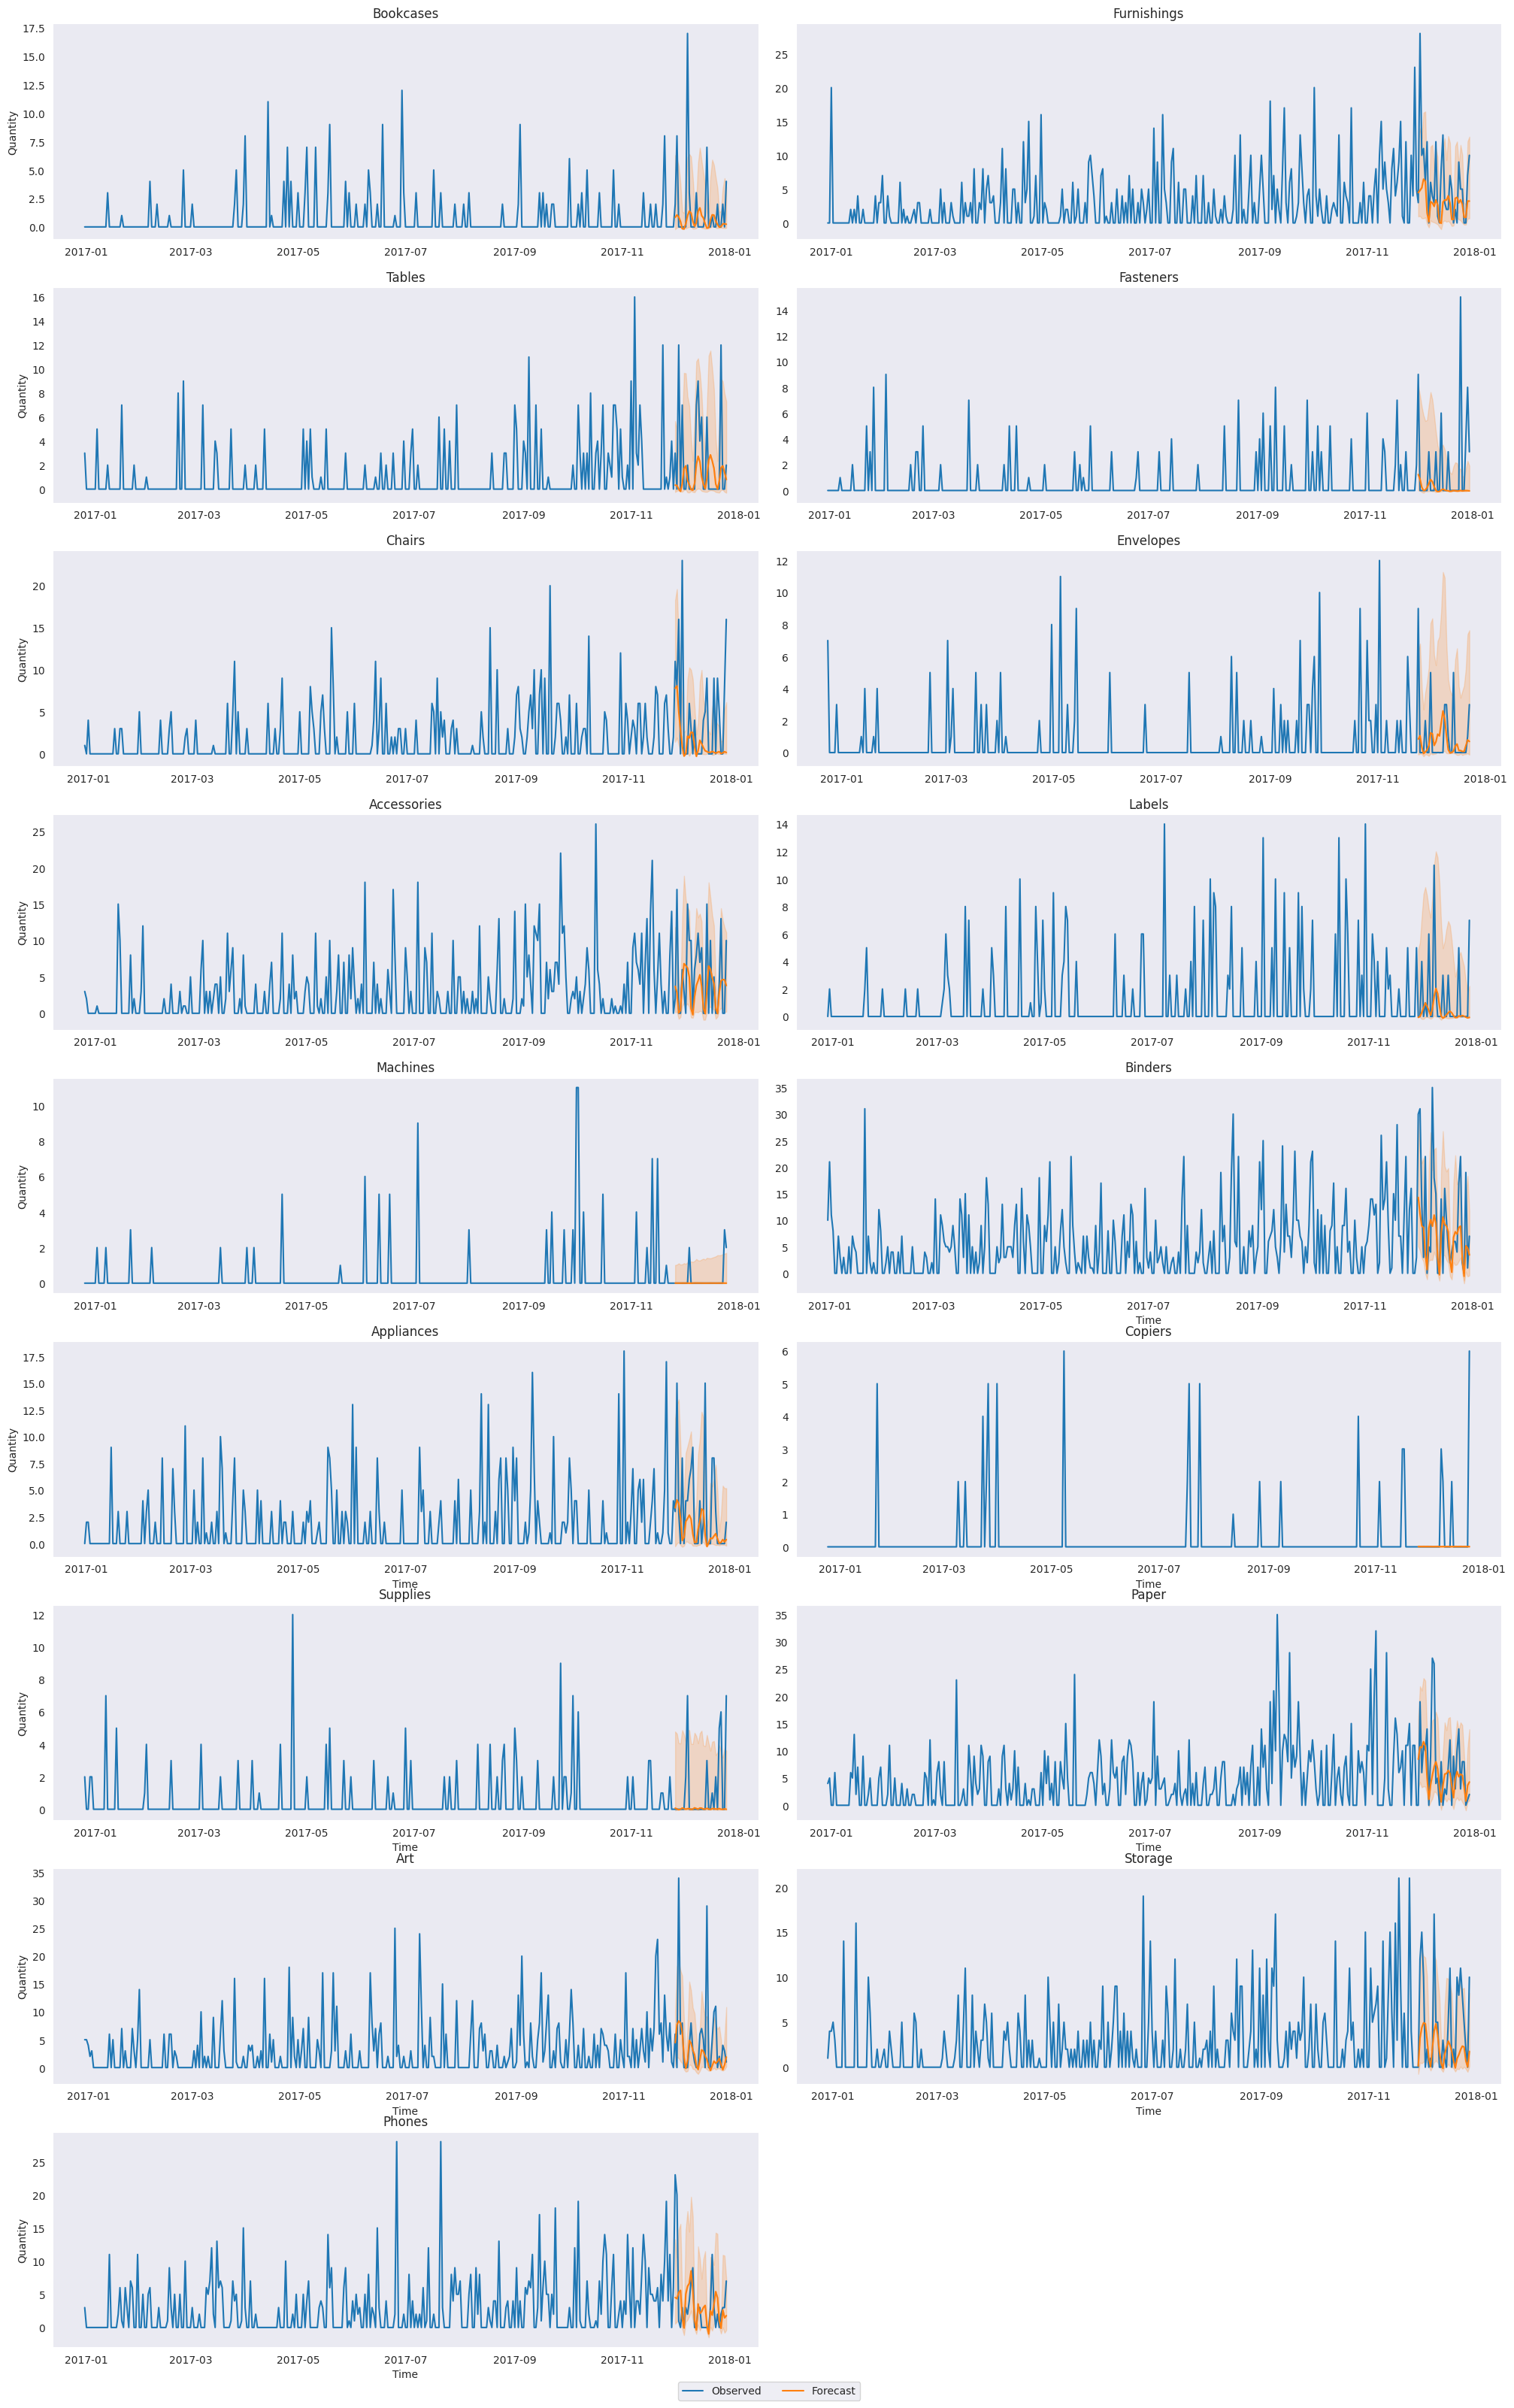

In [28]:
import matplotlib.pyplot as plt

chronos_predictor.plot(data_with_holidays, 
               chronos_predictions, 
            #    quantile_levels=[0.1, 0.9],
               max_history_length=365, 
               max_num_item_ids=20
              );

### Forecast next 30 days

In [29]:
chronos_predictor = TimeSeriesPredictor(
    prediction_length=30,
    target="Quantity",
    known_covariates_names=known_covariates_columns,
    eval_metric="MSE"
).fit(
    train_data=data_with_holidays,
    num_val_windows = 3,
    hyperparameters={
        "Chronos": [
            # FineTuned Chronos-Bolt (Small) combined with XGB on covariates
            {"model_path": "bolt_small", 
             "fine_tune": True,
             "fine_tune_lr": 1e-4, 
             "fine_tune_steps": 3000,
             "keep_transformers_logs": True,
             # "fine_tune_trainer_kwargs": {},
             "covariate_regressor": "XGB",
             "target_scaler": "standard",
             "ag_args": {"name_suffix": "FineTunedWithRegressor"}
            },
        ]
    },
    # time_limit=600,  # time limit in seconds
    enable_ensemble=False,
)


No path specified. Models will be saved in: "AutogluonModels/ag-20250407_135335"
Beginning AutoGluon training...
AutoGluon will save models to '/kaggle/working/AutogluonModels/ag-20250407_135335'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
GPU Count:          1
Memory Avail:       28.97 GB / 31.35 GB (92.4%)
Disk Space Avail:   17.36 GB / 19.52 GB (89.0%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': MSE,
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'FineTunedWithRegressor'},
                                  'covariate_regressor': 'XGB',
                                  'fine_tune': True,
                                  'fine_tune_lr': 0.0001,
                                  'fine_tune_steps': 3000,
                                  'keep_

In [30]:
future_index = get_forecast_horizon_index_ts_dataframe(data_with_holidays, prediction_length=30)
future_timestamps = future_index.get_level_values("timestamp")
known_covariates = pd.DataFrame(index=future_index)

known_covariates['year'] = future_timestamps.year
known_covariates['month'] = future_timestamps.month
known_covariates['weekday'] = future_timestamps.dayofweek
known_covariates['quarter'] = future_timestamps.quarter
known_covariates['is_weekend'] = future_timestamps.dayofweek.isin([5, 6]).astype(int)
known_covariates = add_holiday_features(known_covariates, country_holidays)
known_covariates.head()

year  month  weekday  quarter  is_weekend  \
item_id     timestamp                                               
Accessories 2017-12-26  2017     12        1        4           0   
            2017-12-27  2017     12        2        4           0   
            2017-12-28  2017     12        3        4           0   
            2017-12-29  2017     12        4        4           0   
            2017-12-30  2017     12        5        4           1   

                        Christmas Day  Christmas Day (observed)  Columbus Day  \
item_id     timestamp                                                           
Accessories 2017-12-26            0.0                       0.0           0.0   
            2017-12-27            0.0                       0.0           0.0   
            2017-12-28            0.0                       0.0           0.0   
            2017-12-29            0.0                       0.0           0.0   
            2017-12-30            0.0                       0.0           0.0   

                        Independence Day  Independence Day (observed)  \
item_id     timestamp                                                   
Accessories 2017-12-26               0.0                          0.0   
            2017-12-27               0.0                          0.0   
            2017-12-28               0.0                          0.0   
            2017-12-29               0.0                          0.0   
            2017-12-30               0.0                          0.0   

                        Labor Day  Martin Luther King Jr. Day  Memorial Day  \
item_id     timestamp                                                         
Accessories 2017-12-26        0.0                         0.0           0.0   
            2017-12-27        0.0                         0.0           0.0   
            2017-12-28        0.0                         0.0           0.0   
            2017-12-29        0.0                         0.0           0.0   
            2017-12-30        0.0                         0.0           0.0   

                        New Year's Day  New Year's Day (observed)  \
item_id     timestamp                                               
Accessories 2017-12-26             0.0                        0.0   
            2017-12-27             0.0                        0.0   
            2017-12-28             0.0                        0.0   
            2017-12-29             0.0                        0.0   
            2017-12-30             0.0                        0.0   

                        Thanksgiving  Veterans Day  Veterans Day (observed)  \
item_id     timestamp                                                         
Accessories 2017-12-26           0.0           0.0                      0.0   
            2017-12-27           0.0           0.0                      0.0   
            2017-12-28           0.0           0.0                      0.0   
            2017-12-29           0.0           0.0                      0.0   
            2017-12-30           0.0           0.0                      0.0   

                        Washington's Birthday  Holiday  
item_id     timestamp                                   
Accessories 2017-12-26                    0.0      0.0  
            2017-12-27                    0.0      0.0  
            2017-12-28                    0.0      0.0  
            2017-12-29                    0.0      0.0  
            2017-12-30                    0.0      0.0

In [31]:
chronos_predictions = chronos_predictor.predict(data_with_holidays, 
                                                known_covariates=known_covariates,
                                            #    model = ""
                                                )

Model not specified in predict, will default to the model with the best validation score: ChronosFineTunedWithRegressor[bolt_small]


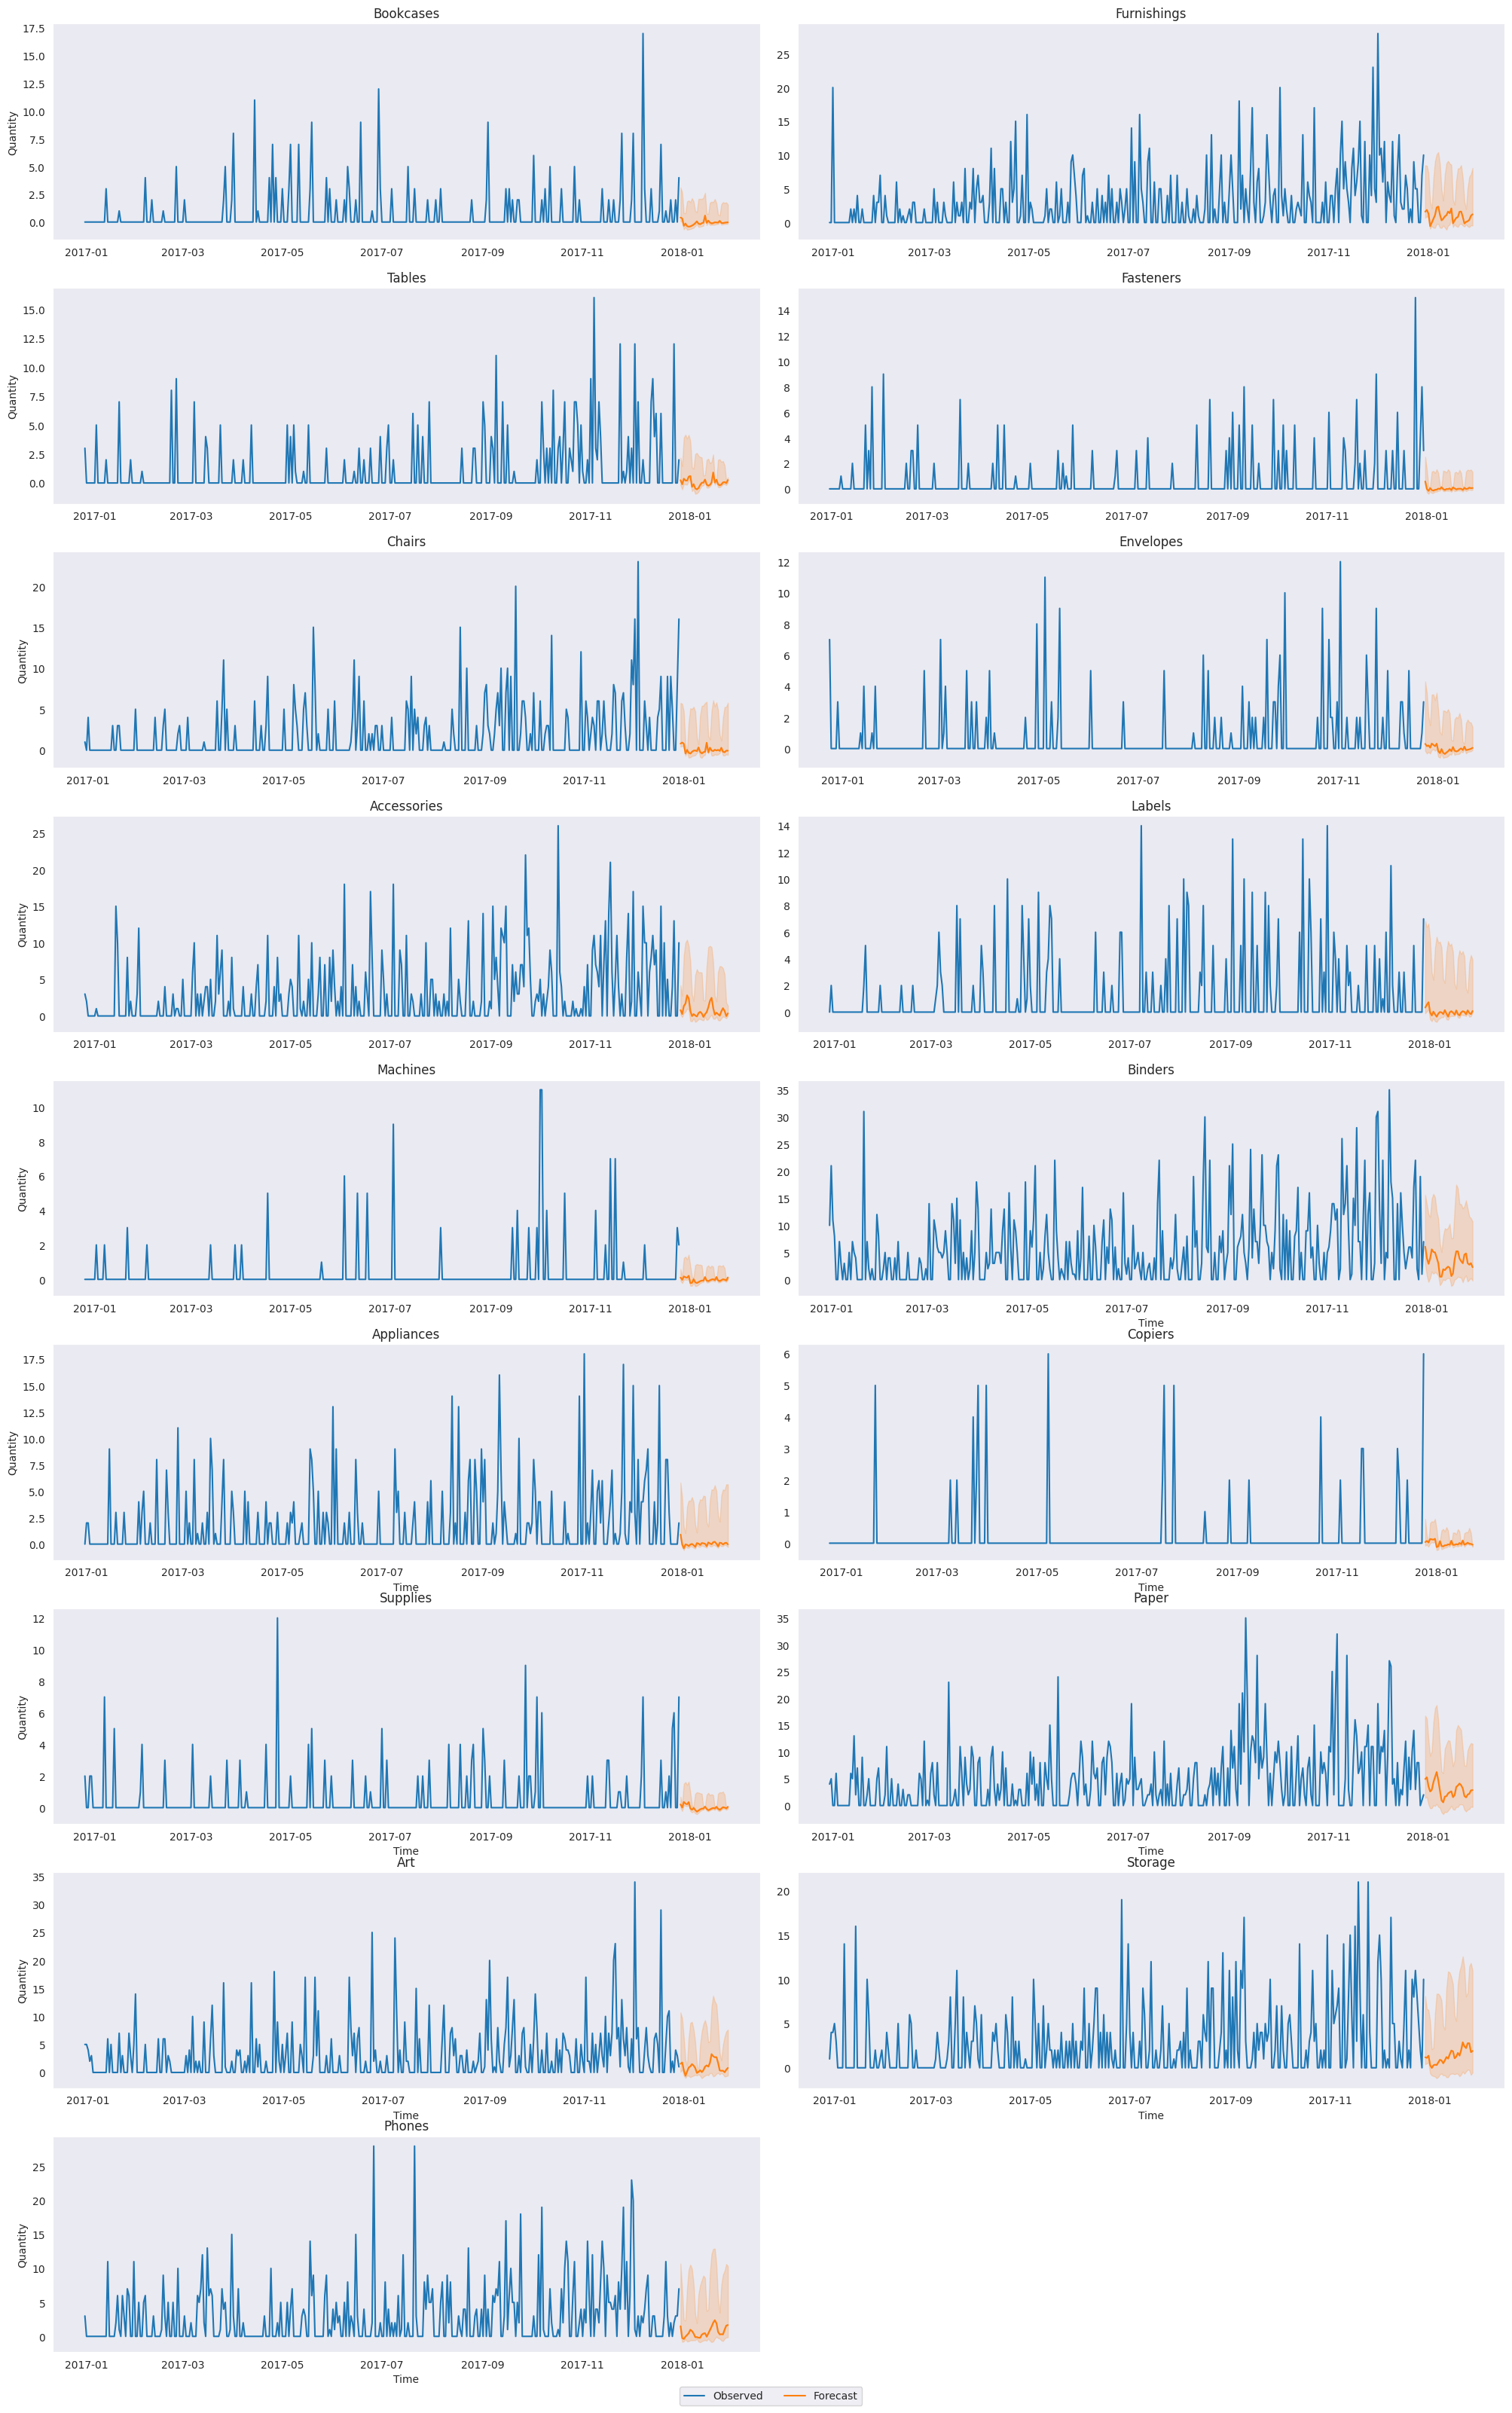

In [32]:
chronos_predictor.plot(data_with_holidays, 
               chronos_predictions, 
            #    quantile_levels=[0.1, 0.9],
               max_history_length=365, 
               max_num_item_ids=20
              );